# Upward Recursion

### Bessel Function Recursion Relation

\begin{equation}
J_{l+1}(x) = \frac{2l+1}{x} J_l - J_{l-1}
\end{equation}

\begin{equation}
J_0(x) = \frac{sin(x)}{x} 
\end{equation}

\begin{equation}
J_1(x) = \frac{sin(x)}{x^2} - \frac{cos(x)}{x}
\end{equation}

In [12]:
import numpy as np

def eval_bessel_func_up(l:int, x:float):
    # At origin; x = 0, Bessel function of any order except zeroth order is zero
    result = np.zeros(l+1) # Since 2nd order Bessel function -> 0, 1, 2
    if abs(x) < 1e-30: # limiting condition for very small x
        result[0] = 1
        return result
    
    J_zero = np.sin(x)/x
    result[0] = J_zero

    if(l == 0): return result

    J_one = J_zero/x - np.cos(x)/x
    result[1] = J_one

    for order in range(1,l):
        J_new = (2*order + 1)/x*J_one - J_zero
        result[order + 1] = J_new
        J_zero, J_one = J_one, J_new
    return result



In [2]:
from scipy import special 
'''
The special library contains the speherical bessel function.
We will use the solution form the special library and our own function and compare results.
'''
order = 10
distance = 0.1

my_data = eval_bessel_func_up(order, distance)
data_from_lib = special.spherical_jn(range(order + 1), distance)

error = my_data - data_from_lib
print(my_data)
print(data_from_lib)
print("Error: ", error)

[9.98334166e-01 0.00000000e+00 6.66190608e-04 9.51851994e-06
 1.05787010e-07 2.31093855e-09 1.48416231e-07 1.92917991e-05
 2.89362145e-03 4.91896354e-01 9.34574137e+01]
[9.98334166e-01 3.33000119e-02 6.66190608e-04 9.51851972e-06
 1.05772015e-07 9.61631023e-10 7.39754109e-12 4.93188748e-14
 2.90120010e-16 1.52698569e-18 7.27151100e-21]
Error:  [ 0.00000000e+00 -3.33000119e-02  4.28758591e-15  2.14271057e-13
  1.49946867e-11  1.34930753e-09  1.48408833e-07  1.92917990e-05
  2.89362145e-03  4.91896354e-01  9.34574137e+01]


# Downward Recursion

### We use downward recursion to minimize error for x << l (Miller's Algorithm)

\begin{equation}
J_{l-1}(x) = \frac{2l+1}{x} J_l - J_{l+1}
\end{equation}


In [3]:
def eval_bessel_func_down(l:int, x:float):
    if abs(x) < 1e-20:
        result = np.zeros(l+1)
        result[0] = 1
        return result
    
    l_start = l + int(np.sqrt(10 * l)) # this is the standard way to set resonable l_max
    # Arbitary initial parameters
    j_next = 0
    j_curr = 1

    result = []
    for order in range(l_start, 0, -1):
        j_prev = (2*order + 1)/x * j_curr - j_next
        if(order - 1 <= l):
            result.append(j_prev)
        j_next, j_curr = j_curr, j_prev
    
    result.reverse() # since the data are stored in reverse order [j_{l}, j_{l-1},.....j_{0}]
    true_j_zero = np.sin(x)/x
    result = np.array(result) * true_j_zero/result[0] #Normalize the series using actual value for zeroth order
    return result


In [4]:
order = 10
angular_displacement = 0.1
my_data = eval_bessel_func_down(order, angular_displacement)
data_from_lib = special.spherical_jn(range(order+1), angular_displacement)
print(f'Error: {my_data - data_from_lib}')
print(f'Downward recursion: {my_data}')
print(f'Library: {data_from_lib}')

Error: [ 0.00000000e+00 -4.16333634e-17 -6.50521303e-19 -1.35525272e-20
 -3.17637355e-22 -2.06795153e-25  6.46234854e-27 -8.20415341e-29
 -3.45126646e-31 -2.88889492e-33 -3.61111865e-35]
Downward recursion: [9.98334166e-01 3.33000119e-02 6.66190608e-04 9.51851972e-06
 1.05772015e-07 9.61631023e-10 7.39754109e-12 4.93188748e-14
 2.90120010e-16 1.52698569e-18 7.27151100e-21]
Library: [9.98334166e-01 3.33000119e-02 6.66190608e-04 9.51851972e-06
 1.05772015e-07 9.61631023e-10 7.39754109e-12 4.93188748e-14
 2.90120010e-16 1.52698569e-18 7.27151100e-21]


In [8]:
def eval_bessel(order:int, angular_dis:float):
    if order <= angular_dis:
        return eval_bessel_func_up(order, angular_dis)
    
    critical_order = int(abs(angular_dis))
    if critical_order <= 0:
        return eval_bessel_func_down(order, angular_dis)
    
    _j_up = eval_bessel_func_up(critical_order -1, angular_dis)
    _j_down = eval_bessel_func_down(order, angular_dis)

    return np.hstack((_j_up, _j_down[critical_order:]))

In [9]:
order = 10
angular_dis = 5.0

data_up = eval_bessel_func_up(order, angular_dis)
data_down = eval_bessel_func_down(order, angular_dis)
data_opt = eval_bessel(order, angular_dis)
data_lib = special.spherical_jn(range(order+1), angular_dis)

print(f'Error for Optimized: {data_opt - data_lib}')
print(f'Error for Upward: {data_up - data_lib}')
print(f'Error for Downward: {data_down - data_lib}')

Error for Optimized: [ 0.00000000e+00  9.50894081e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.32667268e-17 -5.55111512e-17  1.38777878e-17
 -4.33680869e-18 -4.33680869e-19 -1.68051337e-18]
Error for Upward: [ 0.00000000e+00  9.50894081e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.71445147e-17 -8.32667268e-17 -3.46944695e-17
 -1.23165367e-16 -3.58654079e-16 -1.24352568e-15]
Error for Downward: [ 0.00000000e+00  0.00000000e+00 -2.77555756e-17 -2.77555756e-17
  0.00000000e+00 -8.32667268e-17 -5.55111512e-17  1.38777878e-17
 -4.33680869e-18 -4.33680869e-19 -1.68051337e-18]


# Plotting the error

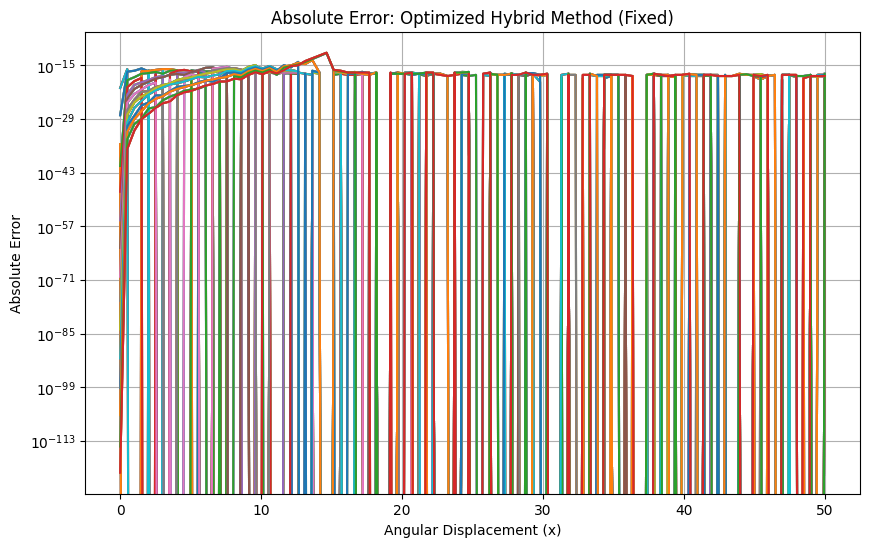

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

order = 15
angular_displacement = np.linspace(1e-6, 50, 100)
data_up = np.array([eval_bessel_func_up(order, dis) for dis in angular_displacement])
data_down = np.array([eval_bessel_func_down(order, dis) for dis in angular_displacement])
data_opt = np.array([eval_bessel(order, dis) for dis in angular_displacement])
reference = np.array([special.spherical_jn(range(order+1), dis) for dis in angular_displacement])



plt.figure(figsize=(10, 6))
for i in range(5, order + 1, 3):
    # Notice the [:, i] - this selects only the error for order 'i'
    plt.semilogy(angular_displacement, np.abs(data_opt - reference), label=f'Order {i}')

plt.title("Absolute Error: Optimized Hybrid Method (Fixed)")
plt.xlabel("Angular Displacement (x)")
plt.ylabel("Absolute Error")
#plt.legend()
plt.grid(True)
plt.show()



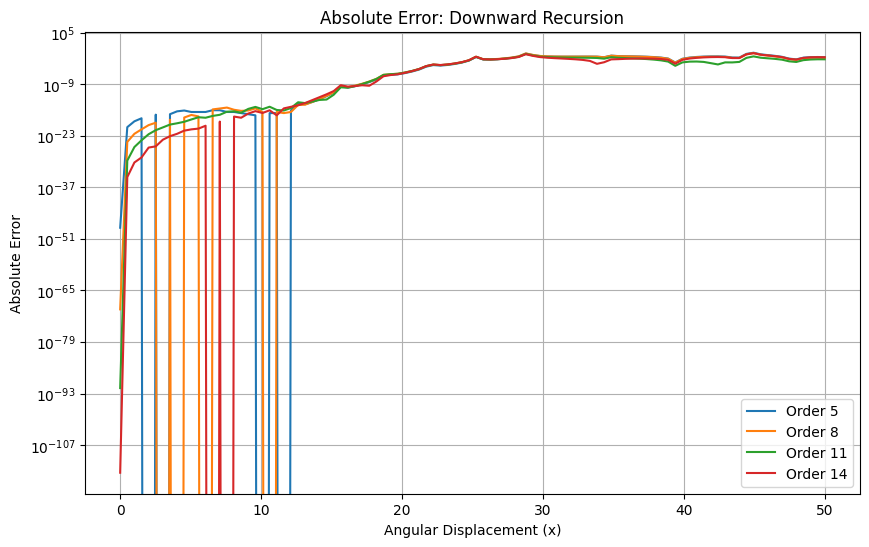

In [15]:
plt.figure(figsize=(10, 6))
for i in range(5, order + 1, 3):
    # Notice the [:, i] - this selects only the error for order 'i'
    plt.semilogy(angular_displacement, np.abs(data_down[:, i] - reference[:, i]), label=f'Order {i}')

plt.title("Absolute Error: Downward Recursion")
plt.xlabel("Angular Displacement (x)")
plt.ylabel("Absolute Error")
plt.legend()
plt.grid(True)
plt.show()

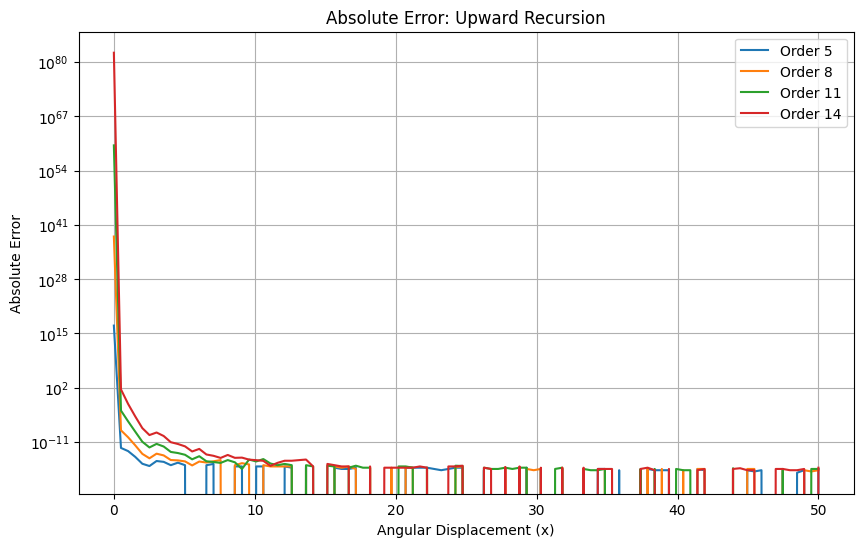

In [16]:
plt.figure(figsize=(10, 6))
for i in range(5, order + 1, 3):
    # Notice the [:, i] - this selects only the error for order 'i'
    plt.semilogy(angular_displacement, np.abs(data_up[:, i] - reference[:, i]), label=f'Order {i}')

plt.title("Absolute Error: Upward Recursion")
plt.xlabel("Angular Displacement (x)")
plt.ylabel("Absolute Error")
plt.legend()
plt.grid(True)
plt.show()